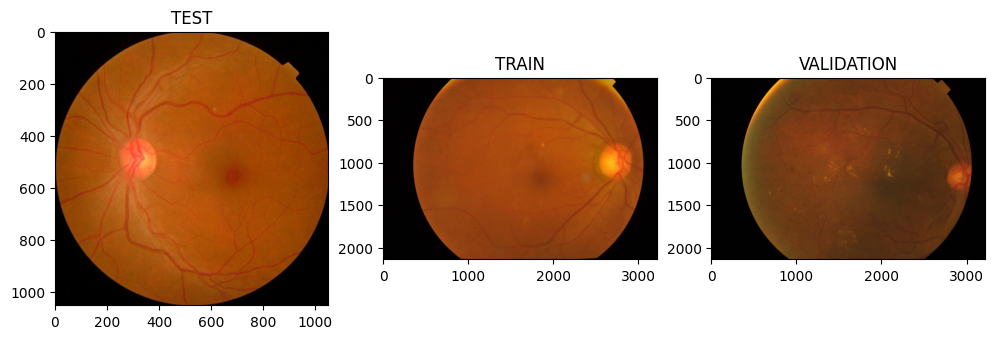

In [4]:
import matplotlib.pyplot as plt
import glob

test_image_path = "./APTOS/test_images/test_images"
train_image_path = "./APTOS/train_images/train_images"
val_image_path = "./APTOS/val_images/val_images"

test_images = sorted(glob.glob(test_image_path + '/*.png'))
train_images = sorted(glob.glob(train_image_path + '/*.png'))
val_images = sorted(glob.glob(val_image_path + '/*.png'))

test_image = test_images[0]
train_image = train_images[0]
val_image = val_images[0]

fig, ax = plt.subplots(1, 3, figsize=(12, 12))

ax[0].imshow(plt.imread(test_image), cmap='gray')
ax[0].set_title('TEST')

ax[1].imshow(plt.imread(train_image), cmap='gray')
ax[1].set_title('TRAIN')

ax[2].imshow(plt.imread(val_image), cmap='gray')
ax[2].set_title('VALIDATION')

plt.show()

In [5]:
import torch
import numpy as np

print(torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

2.5.1+cpu
Device: cpu


In [6]:
from typing import Tuple, Any
from functools import lru_cache
from torchvision.datasets import ImageFolder as _ImageFolder

class ImageFolder(_ImageFolder):
    """
    The ImageFolder provided by torchvision reads from memory every time it's
    indexed. Here, we use an LRU cache so that each image is only read from
    memory once. This will require ~1.5 gigabyte of RAM.

    Compared to the naive implementation, this speeds up training ~60x.
    """
    @lru_cache(maxsize = 10_000)
    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:
            index (int): Index

        Returns:
            tuple: (sample, target) where target is class_index of the target class.
        """
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        if self.target_transform is not None:
            target = self.target_transform(target)

        return sample, target

In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

#TODO: update these values
target_size = (112, 112)

transform = transforms.Compose([
    # Resize images to target size
    transforms.Resize(target_size),
    # Convert images to tensors
    transforms.ToTensor(),
    # Normalize with ImageNet mean and standard deviation ( a common practice )
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets. Use images under 'train' folder for train_dataset and under 'test' folder for test_dataset
train_dataset = ImageFolder("APTOS/train_images", transform)
val_dataset = ImageFolder("APTOS/val_images", transform)
test_dataset = ImageFolder("APTOS/test_images", transform)


# Create data loaders, use a batch size of '64', set shuffle to 'False' and workers to '0'
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False, num_workers=0)
valid_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=0)

In [8]:
from tqdm.auto import tqdm

def verify_loader_size(dataloader, dataset):
    samples = 0
    for batch, labels in tqdm(dataloader):
        samples += len(batch)
    return samples == len(dataset)

# This will take awhile as the images are loaded into memory and cached for the first time.
assert (
    verify_loader_size(train_loader, train_dataset) and
    verify_loader_size(test_loader, test_dataset) and
    verify_loader_size(valid_loader, val_dataset)
)

c:\Users\Chris\Documents\Computer Science\5980\diabetic_retinopathy_classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 6/6 [00:57<00:00,  9.55s/it]


In [9]:
# Notice how much faster it is after caching!
assert (
    verify_loader_size(train_loader, train_dataset) and
    verify_loader_size(test_loader, test_dataset) and
    verify_loader_size(valid_loader, val_dataset)
)

100%|██████████| 6/6 [00:00<00:00, 462.83it/s]
